## Experiment 1
https://www.kaggle.com/code/anfisalepekhina/sketchboost-experiments


В ходе эксперимента оценивается время работы каждого из алгоритмов на сгенерированных данных с разным количеством классов.

In [ ]:
!nvcc --version
!pip install cupy-cuda11x
!pip install py-boost

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 13.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.2 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2023.9.0 which is incompatible.
dask-cudf 23.8.0 requires dask==2023.7.1, but you have dask 2023.9.0 which is incompatible.
dask-cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 2.3 MB/s eta 

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.makedirs('../data', exist_ok=True)
import pandas as pd
from pandas import Series, DataFrame
from sklearn.model_selection import train_test_split
from py_boost import GradientBoosting, SketchBoost
from py_boost.multioutput.sketching import *
from py_boost.multioutput.target_splitter import *
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from catboost.utils import eval_metric
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/cupy/_environment.py:447: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable

Сгенерируем синтетические данные для Multilabel классификации с помощью функции из библиотеки catboost. Сгенерируем сэмплы с разным количеством классов и поочередно запустим алгоритмы и измерим их время. Запишем результаты в соответствующие списки.

In [ ]:
X, Y = make_multilabel_classification(n_samples=30_000, n_features=2_000, n_classes=100, random_state=5)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [ ]:
%%time
model = XGBClassifier(tree_method='gpu_hist',
                      predictor = 'gpu_predictor',
                      gpu_id=0,
                      n_estimators=100)
model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=100)

[0]	validation_0-logloss:0.45781
[99]	validation_0-logloss:0.09038
CPU times: user 1min 3s, sys: 593 ms, total: 1min 3s
Wall time: 58.8 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor='gpu_predictor', random_state=None, ...)

In [ ]:
%%time
model = SketchBoost('logloss',
                    ntrees=100,
                    verbose=100)

model.fit(X_train, Y_train, eval_sets = [{'X': X_test, 'y': Y_test}])

[18:57:39] Stdout logging level is INFO.
[18:57:39] GDBT train starts. Max iter 100, early stopping rounds 100
[18:58:04] Iter 0; Sample 0, BCE = 0.09443555216295903; 
[18:58:09] Iter 99; Sample 0, BCE = 0.09368123648465555; 
CPU times: user 41.4 s, sys: 1.72 s, total: 43.1 s
Wall time: 44.4 s


Полученные результаты запусков на разных сэмплах:

In [ ]:
n_classes=(10, 20, 50, 100)
xgb_time = (6.58, 10.3, 21.2, 36.5)
sketch_time = (6.77, 6.84, 6.95, 10.1)

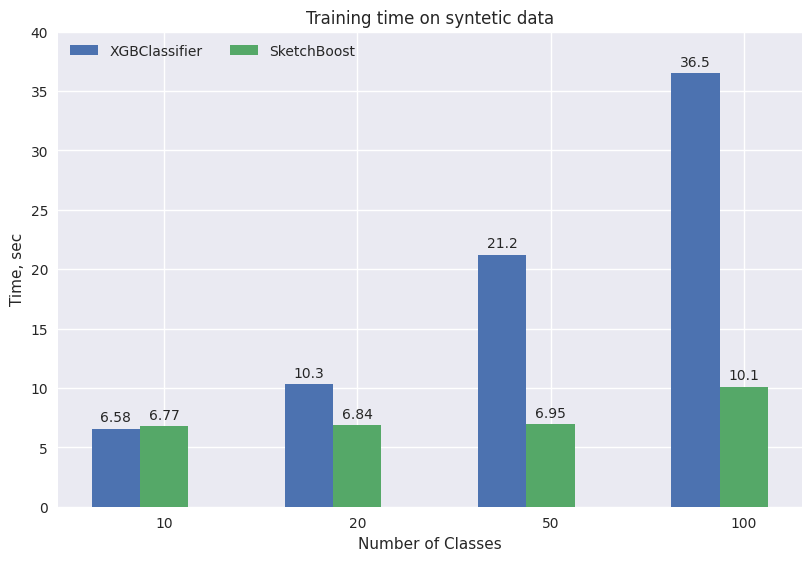

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8')

species = n_classes
penguin_means = {
    'XGBClassifier': xgb_time,
    'SketchBoost': sketch_time,
}

x = np.arange(len(species))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Time, sec')
ax.set_xlabel('Number of Classes')
ax.set_title('Training time on syntetic data')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 40)

plt.show()

## Experiment 2

Сравним время работы и качество алгоритмов на данных банка Точка. Необходимо было на основе признаков клиента классифицировать его на 36 классов. При этом один клиент может являться представителем нескольких классов.

In [ ]:
X = pd.read_csv('/kaggle/input/data-bank/X_train_final_2.csv')
y = pd.read_csv('/kaggle/input/data-bank/y_train_final_2.csv')
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['client_id']).values.astype('float32'),
                                                    y.drop(columns=['client_id']).values.astype('float32'),
                                                    test_size=0.33, random_state=42)

In [ ]:
X.shape, y.shape

((67005, 839), (67005, 36))

In [ ]:
X.head()

,client_id,"('amount', 'mean')","('amount', 'std')","('amount', 'min')","('amount', 'max')","('amount', 'sum')","('flag_0_count', '')","('flag_1_count', '')","('flag_2_count', '')","('flag_3_count', '')",...,contractor_id_986425,contractor_id_3425,contractor_id_137239,contractor_id_373618,contractor_id_26746,contractor_id_860273,contractor_id_96923,contractor_id_853363,contractor_id_953119,contractor_id_124834
0,469347,3.544950e+07,7.754265e+07,12380,1098312208,18362842881,57,0,35,59,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,31053,8.018193e+07,1.162911e+08,73,594908243,7136192030,0,0,0,9,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
2,726736,1.782003e+08,1.873942e+08,31134,726200213,13899625770,0,0,0,28,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
3,438388,2.085516e+07,3.834703e+07,2409,170421023,3837349790,97,0,21,13,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
4,592788,5.818194e+07,6.463688e+07,238581,314723245,9716383639,15,0,3,8,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0


In [ ]:
y.head()

,client_id,type_0,type_1,type_2,type_3,type_4,type_5,type_6,type_7,type_8,...,type_25,type_26,type_27,type_28,type_29,type_30,type_31,type_32,type_33,type_34
0,469347,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,31053,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,726736,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
3,438388,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
4,592788,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
%%time
model = GradientBoosting(
    'crossentropy',
     ntrees=400, lr=0.03, verbose=100, es=300, lambda_l2=1, gd_steps=1,
     subsample=1, colsample=1, min_data_in_leaf=10, use_hess=True,
     max_bin=256, max_depth=6, debug=True
)

model.fit(X_train, y_train,
          eval_sets = [{'X': X_test, 'y': y_test}])

[18:58:25] Stdout logging level is INFO.
[18:58:25] GDBT train starts. Max iter 400, early stopping rounds 300
[18:58:30] Iter 0; Sample 0, Crossentropy = 0.6879615626137843; 
[18:58:38] Iter 100; Sample 0, Crossentropy = 0.5850929207573418; 
[18:58:46] Iter 200; Sample 0, Crossentropy = 0.5797226015021855; 
[18:58:54] Iter 300; Sample 0, Crossentropy = 0.577770803398824; 
[18:59:02] Iter 399; Sample 0, Crossentropy = 0.5767378417009291; 
CPU times: user 47 s, sys: 94 ms, total: 47.1 s
Wall time: 42.7 s


In [ ]:
%%time
model = SketchBoost(
    'crossentropy',
     ntrees=400, lr=0.03, verbose=100, es=300, lambda_l2=1, gd_steps=1,
     subsample=1, colsample=1, min_data_in_leaf=10,
     max_bin=256, max_depth=6,
)

model.fit(X_train, y_train, eval_sets = [{'X': X_test, 'y': y_test}])

[18:59:04] Stdout logging level is INFO.
[18:59:04] GDBT train starts. Max iter 400, early stopping rounds 300
[18:59:04] Iter 0; Sample 0, Crossentropy = 0.6879713105189916; 
[18:59:09] Iter 100; Sample 0, Crossentropy = 0.5855821850163756; 
[18:59:13] Iter 200; Sample 0, Crossentropy = 0.5798950110166738; 
[18:59:18] Iter 300; Sample 0, Crossentropy = 0.5780761295599376; 
[18:59:22] Iter 399; Sample 0, Crossentropy = 0.5771289764195289; 
CPU times: user 24.1 s, sys: 44.3 ms, total: 24.2 s
Wall time: 19.7 s


SketchBoost оказался в 2 раза быстрее стандартного градиентного бустинга, при этом качество решения отличается на 0,0004, что является незначительным отклонением.

## Experiment 3

Сравним время работы и качество алгоритмов на датасете helena OpenML.

In [ ]:
!wget https://www.openml.org/data/get_csv/19335692/file1c556677f875.csv -O ../data/helena.csv

--2023-11-01 18:59:23--  https://www.openml.org/data/get_csv/19335692/file1c556677f875.csv
Resolving www.openml.org (www.openml.org)... 131.155.11.11
Connecting to www.openml.org (www.openml.org)|131.155.11.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘../data/helena.csv’

../data/helena.csv      [         <=>        ]  14.56M  5.16MB/s    in 2.8s    

2023-11-01 18:59:27 (5.16 MB/s) - ‘../data/helena.csv’ saved [15271704]



In [ ]:
data = pd.read_csv('../data/helena.csv')
data.head()

,class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27
0,41,0.005521,0.080556,0.110417,0.490822,0.586406,0.066414,0.092206,0.116352,0.379310,...,-0.342986,78.6894,17.23780,21.504200,14.43730,17.37800,9.61674,-0.609370,1.044830,1.481790
1,92,0.049398,0.147917,0.541667,0.542865,0.515608,0.105128,0.475550,0.049555,0.383460,...,2.639370,59.7879,5.39341,3.819610,11.49240,3.92947,5.91423,1.409210,4.749540,1.103820
2,24,0.548663,1.000000,1.000000,0.397029,0.627398,1.023440,1.004220,0.027381,0.451337,...,0.137427,58.1429,-3.36598,-0.037489,10.63470,2.66018,3.93377,-0.898220,2.137790,1.054470
3,29,0.023073,0.206250,0.238889,0.622998,0.764067,0.202599,0.177892,0.071232,0.531712,...,0.477009,55.4798,-1.05109,-4.755360,13.36710,2.85206,9.65162,0.224397,-0.220216,-0.273287
4,91,0.224427,0.433333,0.902083,0.814199,0.576879,0.344413,0.822975,0.026121,0.425875,...,0.521306,76.8475,-19.37170,32.270700,9.41442,4.34345,8.67710,-1.587580,1.117870,-0.545338


In [ ]:
data['class'].nunique()

100

In [ ]:
X = data.drop('class', axis=1).values.astype('float32')
y = data['class'].values.astype('int32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
%%time
model = GradientBoosting(
    'crossentropy',
     ntrees=10000, lr=0.03, verbose=50, es=300, lambda_l2=1, gd_steps=1,
     subsample=1, colsample=1, min_data_in_leaf=10, use_hess=True,
     max_bin=256, max_depth=6, debug=True
)

model.fit(X_train, y_train,
          eval_sets = [{'X': X_test, 'y': y_test}])

[18:59:27] Stdout logging level is INFO.
[18:59:27] GDBT train starts. Max iter 10000, early stopping rounds 300
[18:59:28] Iter 0; Sample 0, Crossentropy = 4.285501693119262; 
[18:59:35] Iter 50; Sample 0, Crossentropy = 2.964899976657995; 
[18:59:43] Iter 100; Sample 0, Crossentropy = 2.7763024746129266; 
[18:59:51] Iter 150; Sample 0, Crossentropy = 2.6968587815561724; 
[18:59:59] Iter 200; Sample 0, Crossentropy = 2.6534386805047476; 
[19:00:08] Iter 250; Sample 0, Crossentropy = 2.6289803118218185; 
[19:00:16] Iter 300; Sample 0, Crossentropy = 2.612076078388014; 
[19:00:24] Iter 350; Sample 0, Crossentropy = 2.600067458001324; 
[19:00:33] Iter 400; Sample 0, Crossentropy = 2.591465538149357; 
[19:00:41] Iter 450; Sample 0, Crossentropy = 2.5851102270920228; 
[19:00:50] Iter 500; Sample 0, Crossentropy = 2.579336235411552; 
[19:00:58] Iter 550; Sample 0, Crossentropy = 2.575697573939037; 
[19:01:06] Iter 600; Sample 0, Crossentropy = 2.572893503915625; 
[19:01:15] Iter 650; Sample

In [ ]:
%%time
model = SketchBoost(
    'crossentropy',
     ntrees=10000, lr=0.03, verbose=50, es=300, lambda_l2=1, gd_steps=1,
     subsample=1, colsample=1, min_data_in_leaf=10,
     max_bin=256, max_depth=6,
)

model.fit(X_train, y_train, eval_sets = [{'X': X_test, 'y': y_test}])

[19:03:58] Stdout logging level is INFO.
[19:03:58] GDBT train starts. Max iter 10000, early stopping rounds 300
[19:03:58] Iter 0; Sample 0, Crossentropy = 4.37780857729871; 
[19:03:59] Iter 50; Sample 0, Crossentropy = 3.100133290387787; 
[19:04:00] Iter 100; Sample 0, Crossentropy = 2.8830347331944655; 
[19:04:01] Iter 150; Sample 0, Crossentropy = 2.789349040979669; 
[19:04:02] Iter 200; Sample 0, Crossentropy = 2.7344207370052964; 
[19:04:02] Iter 250; Sample 0, Crossentropy = 2.7000160708686116; 
[19:04:03] Iter 300; Sample 0, Crossentropy = 2.6735903535745433; 
[19:04:04] Iter 350; Sample 0, Crossentropy = 2.654487169455045; 
[19:04:05] Iter 400; Sample 0, Crossentropy = 2.6400092242629696; 
[19:04:06] Iter 450; Sample 0, Crossentropy = 2.626303612834556; 
[19:04:07] Iter 500; Sample 0, Crossentropy = 2.616336358202679; 
[19:04:08] Iter 550; Sample 0, Crossentropy = 2.6079282857861035; 
[19:04:09] Iter 600; Sample 0, Crossentropy = 2.6002314212567783; 
[19:04:10] Iter 650; Sampl

In [ ]:
iterations = [0, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
xgb_result = [4.2855, 2.9649, 2.7763, 2.6534, 2.6120, 2.5914, 2.5793, 2.5728, 2.5679,2.5651, 2.5630, 2.5616]
skb_result = [4.3778, 3.10, 2.8830, 2.7344, 2.6735, 2.6400, 2.6163, 2.6002, 2.5880, 2.5780, 2.5651,2.5599 ]

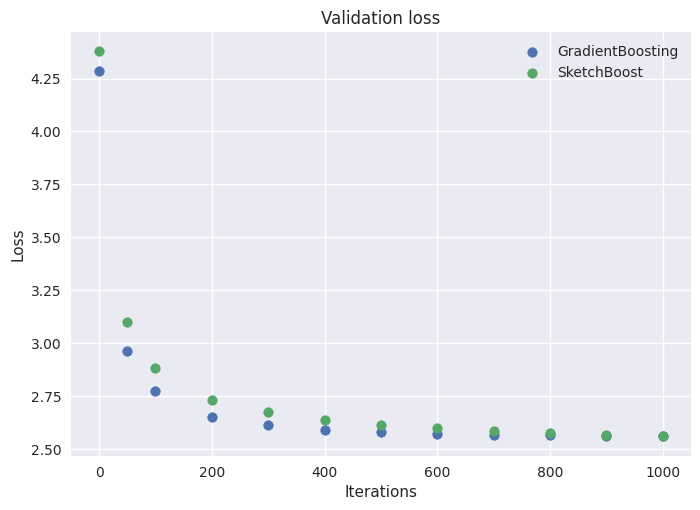

In [ ]:
plt.scatter(iterations, xgb_result, label='GradientBoosting')
plt.scatter(iterations, skb_result, label='SketchBoost')
plt.legend()
plt.title('Validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()